# DE Portofolio 8: Time Series I

This model uses the GTD (Global Terrorism Dataset) data. The dataset includes records of terrorist incidents and events starting 1970, including details such as targets, weapons, terrorist organizations or number of kills. The goal is to forecst the number of terrorist attacks that will occur in the next 100 days globally. The data is filtered to focus on daily records of attacks from 2020 and 2021. While the dataset does not specifically provide a cont of attacks occuring at specifc dates, each attack recorded includes year, month and day. In order to forecast attacks, the counts are a result of date grouping. The notebook will compute Random walk (and with a Drift) models and a third, best performing, model to forecast the number of incidents.

Dataset Source: [https://www.start.umd.edu/gtd/](https://www.start.umd.edu/gtd/)

In [1]:
# load some useful libraries

import statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter 
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
import warnings
warnings.filterwarnings("ignore")

### Load and Prepare Data

In [2]:
df=pd.read_csv('Data_All.csv')
display(df)

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,1_txt
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,PGIS,0,0,0,0,NaN,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,PGIS,0,1,1,1,NaN,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214661,202106300023,2021,6,30,NaN,0,NaN,4,Afghanistan,6,...,"""Gunmen blow up power pylon in Parwan,"" Afghan...","""Provinces hit by blackout after power pylon d...",NaN,START Primary Collection,-9,-9,0,-9,NaN,Electricity
214662,202106300029,2021,6,30,06/30/2021,0,NaN,138,Myanmar,5,...,"""Spring Revolution Daily News for 16-30 June 2...",NaN,NaN,START Primary Collection,-9,-9,0,-9,NaN,Other Personnel
214663,202106300030,2021,6,30,NaN,1,2021-07-08,147,Nigeria,11,...,"""Boko Haram Releases Abducted Catholic Priest ...","""Kidnapped Maiduguri Catholic Priest regains f...","""ISWAP-Boko Haram Abduct Catholic Priest In Bo...",START Primary Collection,0,0,0,0,NaN,Religious Figure
214664,202106300038,2021,6,30,NaN,0,NaN,45,Colombia,3,...,"""Two dead and one wounded after clashes betwee...",NaN,NaN,START Primary Collection,0,0,0,0,NaN,NaN


In [3]:
#Select values from year 2020
df=df[df['iyear']>=2020]
df = df[['eventid','iyear', 'imonth', 'iday', 'region_txt', 'country_txt', 'doubtterr', 'success', 'attacktype1_txt', 'targtype1_txt', 'weaptype1_txt', 'nkill', 'nwound', 'property' ]]

#Remove nans and other values that do not provide meaning
values_to_replace = ['Unknown', 'Other', -99, -9]
df.replace(values_to_replace, np.nan, inplace=True)
df=df.dropna()
display(df)

,eventid,iyear,imonth,iday,region_txt,country_txt,doubtterr,success,attacktype1_txt,targtype1_txt,weaptype1_txt,nkill,nwound,property
201268,202001010001,2020,1,1,South Asia,Nepal,0,1,Facility/Infrastructure Attack,Telecommunication,Incendiary,0.0,0.0,1.0
201269,202001010002,2020,1,1,South Asia,Nepal,0,0,Bombing/Explosion,Telecommunication,Explosives,0.0,0.0,0.0
201271,202001010005,2020,1,1,South Asia,Afghanistan,0,1,Bombing/Explosion,Private Citizens & Property,Explosives,3.0,0.0,1.0
201272,202001010006,2020,1,1,South Asia,Bangladesh,0,1,Bombing/Explosion,Educational Institution,Explosives,0.0,0.0,0.0
201276,202001010010,2020,1,1,South Asia,Pakistan,1,1,Bombing/Explosion,Police,Explosives,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214658,202106300016,2021,6,30,Middle East & North Africa,Saudi Arabia,0,0,Bombing/Explosion,Private Citizens & Property,Explosives,0.0,0.0,0.0
214659,202106300017,2021,6,28,Sub-Saharan Africa,Central African Republic,0,1,Armed Assault,Government (Diplomatic),Firearms,7.0,0.0,0.0
214661,202106300023,2021,6,30,South Asia,Afghanistan,0,1,Bombing/Explosion,Utilities,Explosives,0.0,0.0,1.0
214663,202106300030,2021,6,30,Sub-Saharan Africa,Nigeria,0,1,Hostage Taking (Kidnapping),Religious Figures/Institutions,Firearms,0.0,0.0,0.0


In [4]:
#Filter dataframe to dates and attack numbers

#Slice eventid string to focus only on the dates and remove identification code (last 4 digits)
df['eventid'] = df['eventid'].astype(str).str[:8] 

#Convert eventid to datetime
df['eventid'] = pd.to_datetime(df['eventid'], format='%Y%m%d', errors='coerce')

#Count how many attacks occured by grouping them absed on same date
time_data = df.groupby('eventid').size().reset_index(name='number_attacks')

#Drop duplicates and nans
time_data = time_data[['eventid','number_attacks']].drop_duplicates()
time_data=time_data.dropna()
display(time_data)



,eventid,number_attacks
0,2020-01-01,10
1,2020-01-02,12
2,2020-01-03,11
3,2020-01-04,13
4,2020-01-05,19
...,...,...
543,2021-06-27,30
544,2021-06-28,31
545,2021-06-29,23
546,2021-06-30,15


### Visualize Data

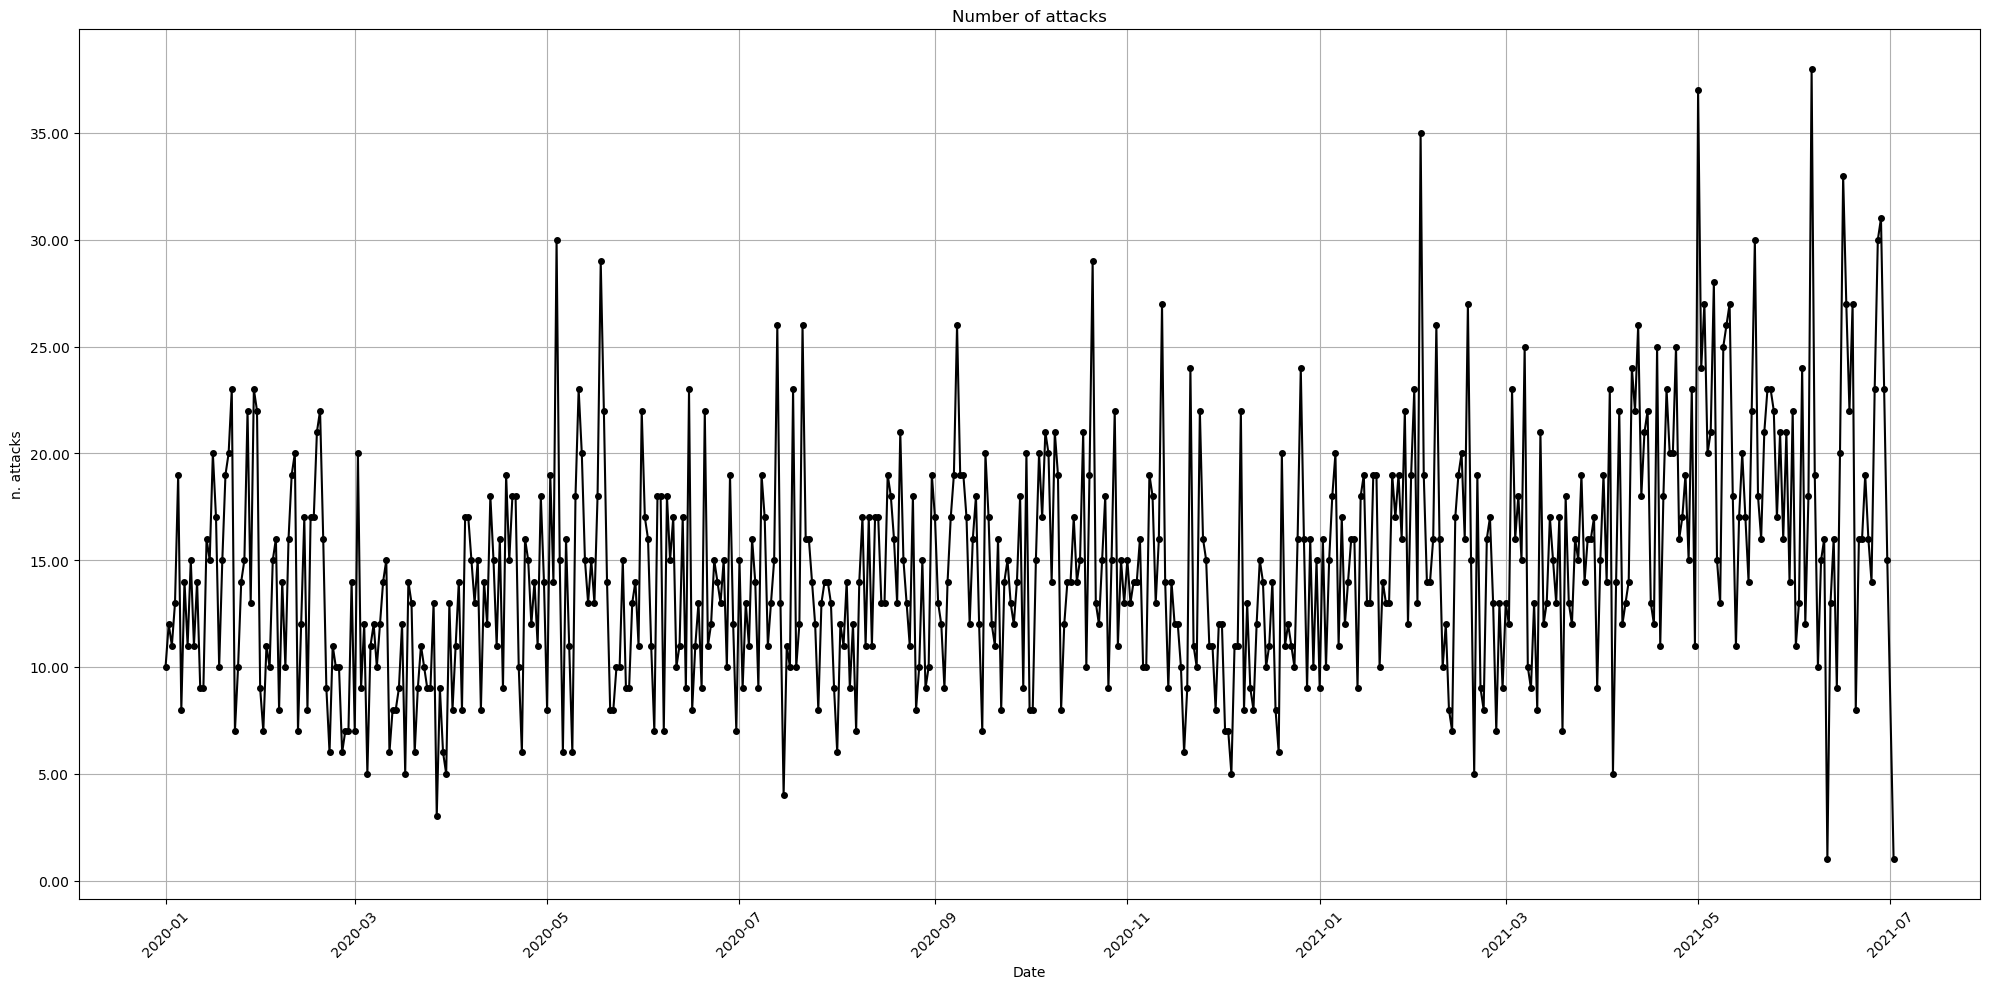

In [5]:
#Convert dates to datetime format
df['eventid'] = pd.to_datetime(df['eventid'])

# Plot data
plt.figure(figsize=(20, 10))
plt.plot(time_data['eventid'], time_data['number_attacks'], marker='o', linestyle='-', color='black',markersize = '4')
plt.title('Number of attacks')
plt.xlabel('Date')
plt.ylabel('n. attacks')
plt.grid(True)

# Manually format y-axis labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The data looks stationary so we do not have to change it.

In [6]:
#Additional check on whether the model is stationary with Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(time_data['number_attacks'].dropna())

adf_output = pd.Series(adf_result[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_result[4].items():
    adf_output[f'Critical Value ({key})'] = value

adf_output

Test Statistic                  -3.046916
p-value                          0.030739
#Lags Used                      12.000000
Number of Observations Used    535.000000
Critical Value (1%)             -3.442632
Critical Value (5%)             -2.866957
Critical Value (10%)            -2.569655
dtype: float64

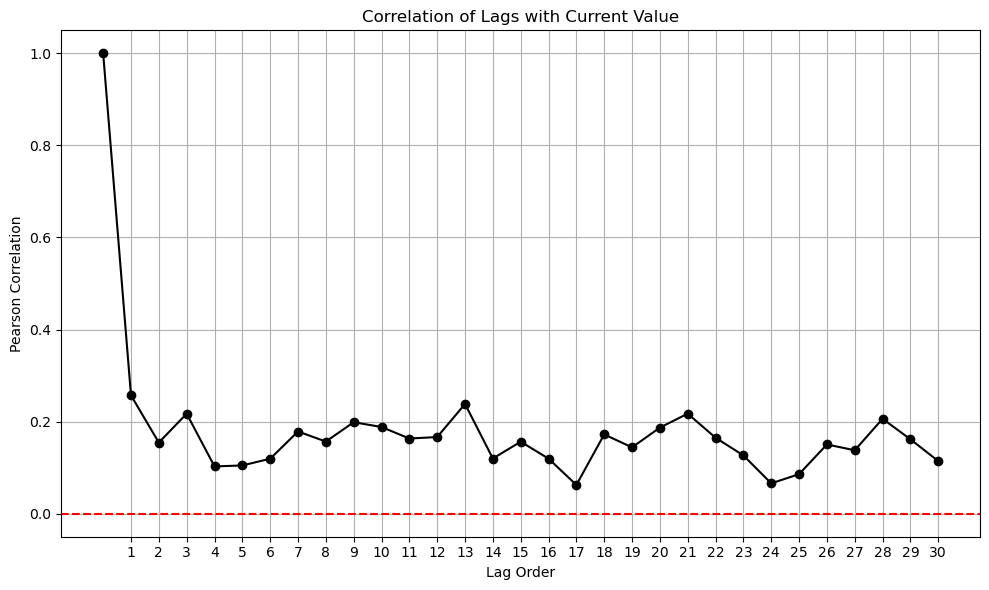

In [7]:
from scipy.stats import pearsonr

#Add first 30 lags to the series
lags = 30
for lag in range(0, lags + 1):
    time_data[f'lag_{lag}'] = time_data['number_attacks'].shift(lag)

#Calculate pearson correlation per lags
correlations = []
for lag in range(0, lags + 1):
    corr = pearsonr(time_data.dropna()['number_attacks'], time_data.dropna()[f'lag_{lag}'])[0]
    correlations.append(corr)

#Plot correlations of lags
plt.figure(figsize=(10, 6))
plt.plot(range(0, lags + 1), correlations, marker='o', linestyle='-', color='black')
plt.axhline(y=0, color='r', linestyle='--')  
plt.title('Correlation of Lags with Current Value')
plt.xlabel('Lag Order')
plt.ylabel('Pearson Correlation')
plt.grid(True)
plt.xticks(range(1, lags + 1))
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

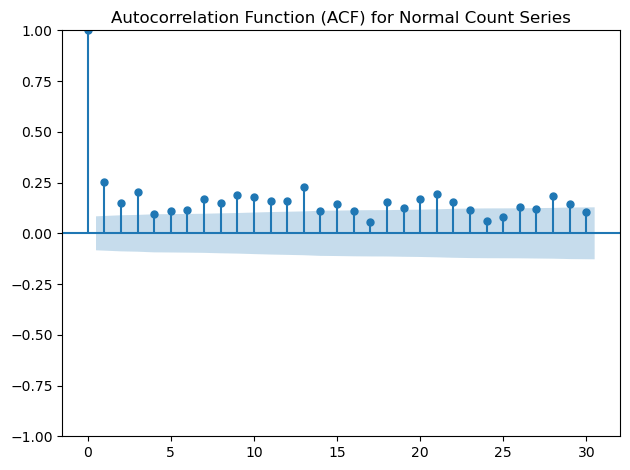

<Figure size 1200x600 with 0 Axes>

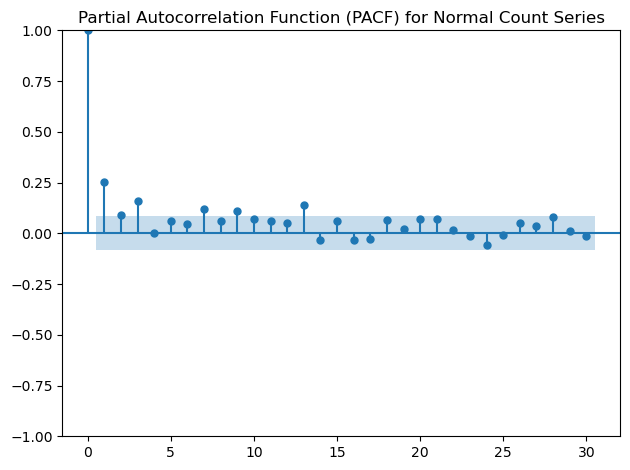

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Plot Autocorrelation Function (ACF)
plt.figure(figsize=(12, 6))
plot_acf(time_data['number_attacks'].dropna(), lags=30, alpha=0.05, title='Autocorrelation Function (ACF) for Normal Count Series')
plt.tight_layout()

#Plot Partial Autocorrelation Function (PACF)
plt.figure(figsize=(12, 6))
plot_pacf(time_data['number_attacks'].dropna(), lags=30, alpha=0.05, title='Partial Autocorrelation Function (PACF) for Normal Count Series')
plt.tight_layout()

plt.show()


### Fit Random Walk Model

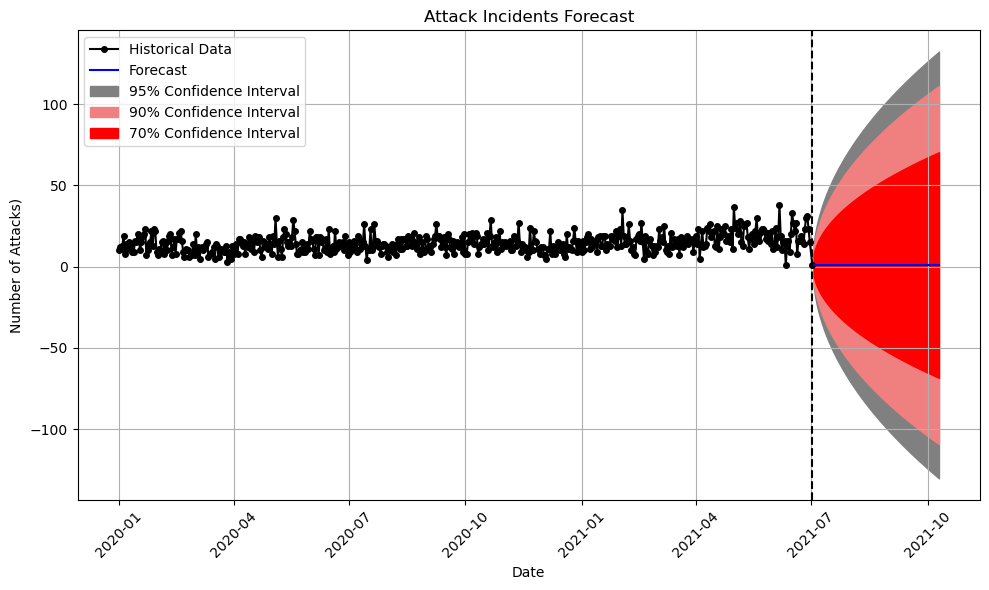

In [9]:
#Fit random walk
model = ARIMA(time_data['number_attacks'], order=(0, 1, 0))
model_fit = model.fit()

#Forecast for the next 100 days
forecast = model_fit.get_forecast(steps=100)

#Get the mean and confidence intervals of forecasts
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int(alpha=0.05)  # 95% confidence interval
conf_int_70 = forecast.conf_int(alpha=0.30)  # 70% confidence interval
conf_int_90 = forecast.conf_int(alpha=0.10)  # 90% confidence interval

#Get forecats dates -- We are forecasting for next 100 days
forecast_dates = pd.date_range(start=time_data['eventid'].iloc[-1] + pd.Timedelta(days=1), periods=100)

#Plot the historical data
plt.figure(figsize=(10, 6))
plt.plot(time_data['eventid'], time_data['number_attacks'], marker='o', linestyle='-', color='black', markersize=4, label='Historical Data')

#Plot the forecasted data
plt.plot(forecast_dates, forecast_mean, color='blue', label='Forecast')

#Plot all confidence intervals
plt.fill_between(forecast_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='grey', alpha=1, label='95% Confidence Interval')
plt.fill_between(forecast_dates, conf_int_90.iloc[:, 0], conf_int_90.iloc[:, 1], color='lightcoral', alpha=1, label='90% Confidence Interval')
plt.fill_between(forecast_dates, conf_int_70.iloc[:, 0], conf_int_70.iloc[:, 1], color='red', alpha=1, label='70% Confidence Interval')


#Divide historical data and forecasted data
plt.axvline(x=time_data['eventid'].iloc[-1], color='black', linestyle='--')
plt.title('Attack Incidents Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Attacks)')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Explanation of graph: Considering that we are forecasting number of attacks per day, it can be assumed that the model shows the number of attacks will not changing, being around 1 or 2 attacks per day. Based on the plot, we can argue that this model does not properly show forecasts. This can be due to the values being close to 0 and following a non-Gaussian distribution.

### Fit Random Walk with Drift

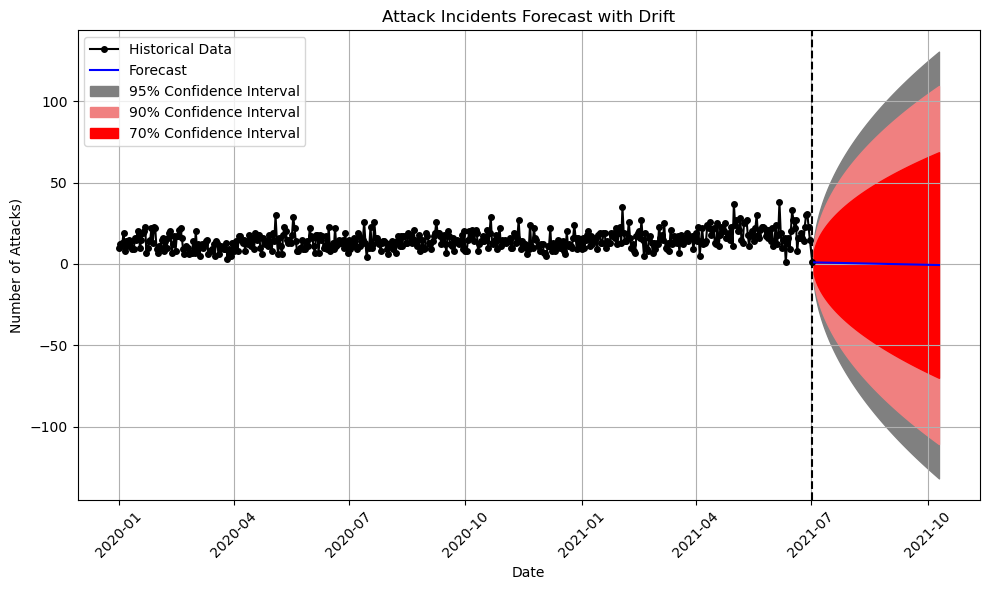

In [10]:
# Fit a random walk with drift
model = ARIMA(time_data['number_attacks'], order=(0, 1, 0), trend='t')
model_fit = model.fit()

#Forecast for the next 100 days
forecast = model_fit.get_forecast(steps=100)

#Get mean and confidence intervals for forecasts
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int(alpha=0.05)  # 95% confidence interval
conf_int_70 = forecast.conf_int(alpha=0.30)  # 70% confidence interval
conf_int_90 = forecast.conf_int(alpha=0.10)  # 90% confidence interval

# Forecast dates
forecast_dates = pd.date_range(start=time_data['eventid'].iloc[-1] + pd.Timedelta(days=1), periods=100)

# Plot the historical data
plt.figure(figsize=(10, 6))
plt.plot(time_data['eventid'], time_data['number_attacks'], marker='o', linestyle='-', color='black', markersize=4, label='Historical Data')

# Plot the forecast
plt.plot(forecast_dates, forecast_mean, color='blue', label='Forecast')

# Plot the confidence intervals
plt.fill_between(forecast_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='grey', alpha=1, label='95% Confidence Interval')
plt.fill_between(forecast_dates, conf_int_90.iloc[:, 0], conf_int_90.iloc[:, 1], color='lightcoral', alpha=1, label='90% Confidence Interval')
plt.fill_between(forecast_dates, conf_int_70.iloc[:, 0], conf_int_70.iloc[:, 1], color='red', alpha=1, label='70% Confidence Interval')


# Delineate the start of the forecast with a solid black line
plt.axvline(x=time_data['eventid'].iloc[-1], color='black', linestyle='--')

plt.title('Attack Incidents Forecast with Drift')
plt.xlabel('Date')
plt.ylabel('Number of Attacks)')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Explanation of graph: The same assumption can be made for a Random Walk with a Drift. Howeevr, in this case we see the forecasted values decrease, reaching 0 attacks per day in September 2021. As mentioned above, this model and plot are not effective in showing time trends and forecasts in the future.

#### Calculate probabilities

In [11]:
#Get last forecast interval
last_conf_int = conf_int.iloc[-1]

#Calculate range of forecasts
range_conf_int = last_conf_int['upper number_attacks'] - last_conf_int['lower number_attacks']

#Estimate the standard deviation
estimated_std_dev = range_conf_int / 4

In [12]:
#Simulating 10000 for attack count
simulated_values = np.random.normal(loc=forecast_mean.iloc[-1], scale=estimated_std_dev, size=1000)

#Calculate probability of attack count to be over 5
prob_above_5 = (simulated_values > 5).mean()

print(prob_above_5)

0.453


This probability implies that in the values forecasted for the next 100 days, there is a low probability of the attacks to be over 5 per day.

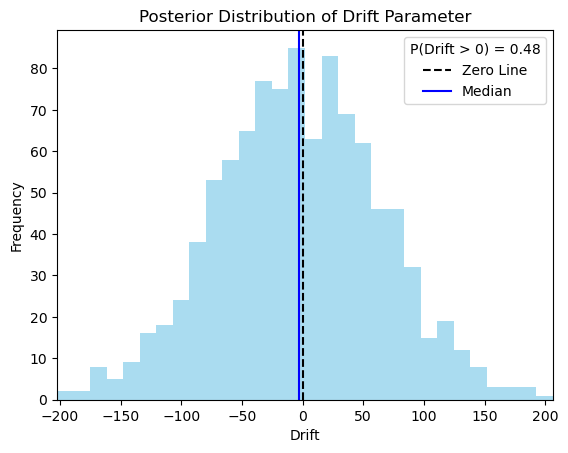

In [13]:
#Calculate probability of simulations to be above 0
prob_above_0 = (simulated_values> 0).mean()

#Plot posterior distribution of Drift
plt.hist(simulated_values, bins=30, alpha=0.7,color = 'skyblue')
plt.axvline(0, color='k', linestyle='--', label='Zero Line')
plt.axvline(np.median(simulated_values), color='blue', linestyle='-', label='Median')

plt.legend(title=f'P(Drift > 0) = {prob_above_0:.2f}')
plt.title("Posterior Distribution of Drift Parameter")
plt.xlabel("Drift")
plt.ylabel("Frequency")

# Ensure the range of x always includes 0
plt.xlim(min(-0.5, simulated_values.min()), max(0.5, simulated_values.max()))

plt.show()

### Selecting the best model

In [14]:
from pmdarima import auto_arima
time_data=time_data.dropna()
#Detect the optimal ARIMA parameters by iterating through model order to minimize AIC
model = auto_arima(time_data['number_attacks'], start_p=0, start_q=0,
                   test='adf',       
                   max_p=5, max_q=5, 
                   m=1,             
                   d=None,           
                   seasonal=False,   
                   start_P=0, 
                   D=0, 
                   trace=True,
                   error_action='ignore',  
                   suppress_warnings=True, 
                   stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4322.671, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3424.942, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3926.484, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3334.603, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=3269.864, Time=0.08 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=3262.331, Time=0.11 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=3251.682, Time=0.16 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=3180.731, Time=0.47 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=3182.336, Time=0.35 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=inf, Time=0.86 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=3180.553, Time=0.62 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=3179.123, Time=0.40 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3177.632, Time=0.30 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3181.011, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0]             : 

In [15]:
#Extract the order for the best performing model
order = model.order
print(order)

(2, 0, 2)


### Fit Best Performing Model

In [16]:
#Fit model
model = ARIMA(time_data['number_attacks'], order=order)
model_fit = model.fit()

#Forecast for the next 100 days
forecast = model_fit.get_forecast(steps=100)

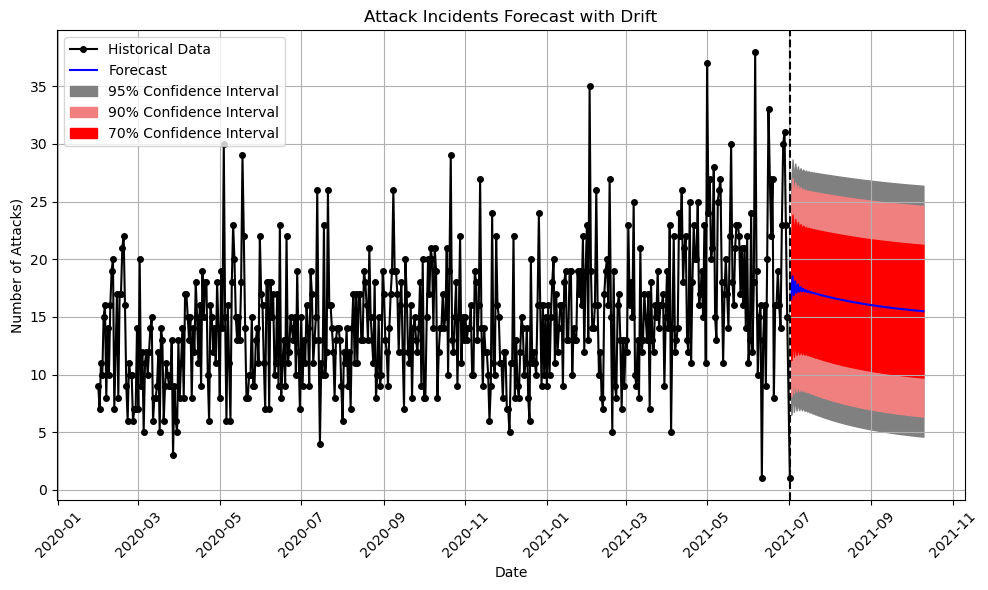

In [17]:
#Extract mean and confidence interval of forecasts
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int(alpha=0.05)  # 95% confidence interval
conf_int_70 = forecast.conf_int(alpha=0.30)  # 70% confidence interval
conf_int_90 = forecast.conf_int(alpha=0.10)  # 90% confidence interval

#Get forecast dates
forecast_dates = pd.date_range(start=time_data['eventid'].iloc[-1] + pd.Timedelta(days=1), periods=100)

#Plot historical data
plt.figure(figsize=(10, 6))
plt.plot(time_data['eventid'], time_data['number_attacks'], marker='o', linestyle='-', color='black', markersize=4, label='Historical Data')

#Plot forecasted data
plt.plot(forecast_dates, forecast_mean, color='blue', label='Forecast')

#Plot the confidence intervals
plt.fill_between(forecast_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='grey', alpha=1, label='95% Confidence Interval')
plt.fill_between(forecast_dates, conf_int_90.iloc[:, 0], conf_int_90.iloc[:, 1], color='lightcoral', alpha=1, label='90% Confidence Interval')
plt.fill_between(forecast_dates, conf_int_70.iloc[:, 0], conf_int_70.iloc[:, 1], color='red', alpha=1, label='70% Confidence Interval')


#Separate historical and forecasted data
plt.axvline(x=time_data['eventid'].iloc[-1], color='black', linestyle='--')

plt.title('Attack Incidents Forecast with Drift')
plt.xlabel('Date')
plt.ylabel('Number of Attacks)')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

This model provides a better forecasting in comparion to the Random Walk models, showing that the mean average forecasted for the next 100 days decreases from 20 to 16 attacks per day.

In [18]:
# Using a manual function to find the best model:

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

#Define data used
data = time_data['number_attacks']

#Define and determine splits
n_splits = 10
total_size = len(data)
split_size = int(total_size / n_splits)

#Initialize empty lsit for RMSE scores
scores = []

for split in range(1, n_splits + 1):
    
    #Get index for splititng the data
    split_index = split_size * split
    
    #Ensure we do not go beyond the dataset's size
    if split_index > total_size:
        break
    
    #Create test and train sets
    train, test = data[:split_index], data[split_index:split_index + split_size]
    
    #Fit best model
    model = ARIMA(train, order = order)  
    model_fit = model.fit()
    
    #Generate forecasts
    forecast = model_fit.forecast(steps=len(test))
    
    #Calculate and append RMSE
    mse = mean_squared_error(test, forecast)
    rmse = np.sqrt(mse)
    scores.append(rmse)

#Calculate average RMSE from all scores
average_score = np.mean(scores)
print(f'Average RMSE: {average_score}')


Average RMSE: 5.680530716325101


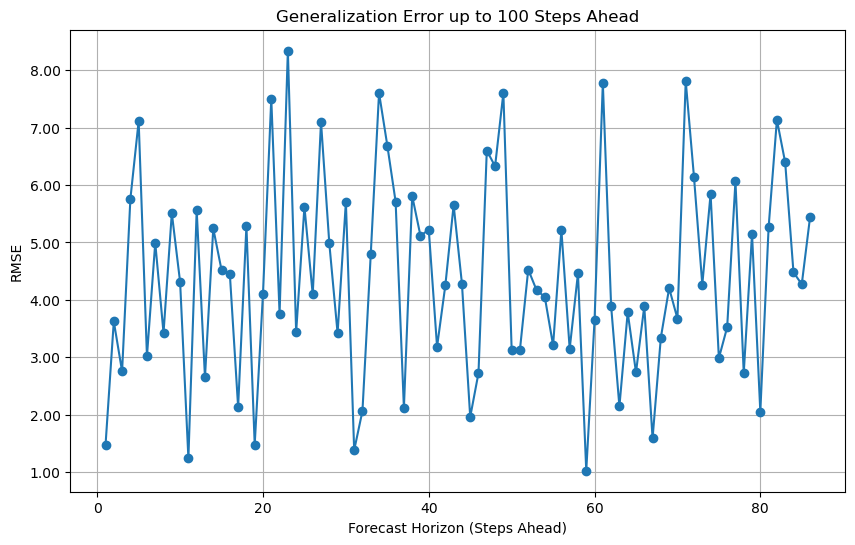

In [19]:
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

#Define data used
data = time_data['number_attacks']

#Define number of splits
n_splits = 5
max_forecast_horizon = 100 # Maximum forecast horizon -- set for 100 days
errors = [] #Collecting errors

tscv = TimeSeriesSplit(n_splits=n_splits)

#Split data in test and train index
for train_index, test_index in tscv.split(data):
    train, test = data.iloc[train_index], data.iloc[test_index]
    available_forecast_horizon = min(len(test), max_forecast_horizon)
    
    #Fit model
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    
    #Generate forecasts
    forecast = model_fit.forecast(steps=available_forecast_horizon)

    #Calculate true values
    true_values = test.iloc[:available_forecast_horizon].reset_index(drop=True)
    
    #Calculate errors
    fold_errors = np.zeros(available_forecast_horizon)
    for step in range(available_forecast_horizon):
        #Get forecast values and calculate RMSE
        forecast_values = np.array(forecast) if not isinstance(forecast, np.ndarray) else forecast
        mse = mean_squared_error([true_values.iloc[step]], [forecast_values[step]])
        rmse = np.sqrt(mse)
        fold_errors[step] = rmse
    
    errors.append(fold_errors)

# To handle varying lengths, we need to average errors for each step across all folds differently
max_length = max(len(e) for e in errors)  # Find the maximum forecast horizon across folds
average_errors = np.zeros(max_length)
for i in range(max_length):
    step_errors = [e[i] for e in errors if i < len(e)]  # Collect ith error from each fold if it exists
    average_errors[i] = np.mean(step_errors)  # Average those errors

# Plot the generalization error as a function of forecast horizon
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_length + 1), average_errors, marker='o')
plt.title('Generalization Error up to 100 Steps Ahead')
# Manually format y-axis labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
plt.xlabel('Forecast Horizon (Steps Ahead)')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()
